<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/analyze_keypoint_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes a YOLOv8 set of pose labels to understand the distribution of keypoints, links connecting keypoints, and possible ratios between links, in the labels.  This gives us an idea of how realistic it is to use pose data as a way to identify different images of the same cat.  Apart from the accuracy of the pose estimation model, just the presence or absence of keypoints limits the kind of comparisons we can do.

In [14]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
!unzip feral-cat-pose-detection-6.v4i.yolov8.zip

Archive:  feral-cat-pose-detection-6.v4i.yolov8.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/group0002_jpeg_cat-4_png.rf.5405d08e974c586e35ed6661df314415.jpg  
 extracting: test/images/group0006_jpeg_cat-0_png.rf.a2664719e5fac6b27537d25990fbca75.jpg  
 extracting: test/images/group0006_jpeg_cat-9_png.rf.f68a1aac4e761557adbb921d92a0b81e.jpg  
 extracting: test/images/group0010_jpeg_cat-1_png.rf.39707877a9b1f4d548e0e9c1f4725ae4.jpg  
 extracting: test/images/group0017_jpeg_cat-2_png.rf.96056f3114ec4674f2f8c0a4c6c8b49d.jpg  
 extracting: test/images/group0059_jpeg_cat-1_png.rf.02701404279548e7995db202e7b77cee.jpg  
 extracting: test/images/group0067_cat-5_png.rf.f7f50b8af5d6a2b0223b118b8f0da62d.jpg  
 extracting: test/images/group0069_jpeg_cat-0_png.rf.9c101f4bdcd929846a220b6cb3c92368.jpg  
 extracting: test/images/group0092_jpeg_cat-3_png.rf.b2723

In [4]:
# YOLOv8 label data is stored in one text file corresponding to one image.
# Get all the text files for the training, validation, and testing of the model.
label_files = glob.glob('train/labels/*.txt')
label_files.extend(glob.glob('valid/labels/*.txt'))
label_files.extend(glob.glob('test/labels/*.txt'))
print(len(label_files))

1125


In [5]:
# Define the names of keypoints in the same order they are defined in Roboflow.  To determine this,
# export the dataset in COCO format (see this link, click Generate, and choose the COCO format:
# https://app.roboflow.com/feralcatposeestimation/feral-cat-pose-detection-6/4).  Within the JSON file
# _annotations.coco.json, find the "categories" entry, which is an array, and check the second item
# in the array, which is the list of names of keypoints in the order in which they are output to
# a lable file.
keypoints = ["left_earbase",
                "right_earbase",
                "left_eye",
                "right_eye",
                "nose",
                "mouth",
                "withers",
                "tailbase",
                "left_elbow",
                "left_wrist",
                "left_front_paw",
                "right_elbow",
                "right_wrist",
                "right_front_paw",
                "left_knee",
                "left_ankle",
                "left_rear_paw",
                "right_knee",
                "right_ankle",
                "right_rear_paw"]
columns = ['filename']
columns.extend(keypoints)

In [6]:
# A link is defined by two keypoints.  The following named links are the ones that
# seem to make sense.
links = {'earbases': ["left_earbase", "right_earbase"],
         'eyes': ["left_eye", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'left_ear_to_eye': ["left_earbase", "left_eye"],
         'right_ear_to_eye': ["right_earbase", "right_eye"],
         'left_eye_to_nose': ["nose", "left_eye"],
         'right_eye_to_nose': ["nose", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'withers_to_tailbase': ["withers", "tailbase"],
         'left_elbow_to_wrist': ["left_elbow", "left_wrist"],
         'right_elbow_to_wrist': ["right_elbow", "right_wrist"],
         'left_knee_to_ankle': ["left_knee", "left_ankle"],
         'right_knee_to_ankle': ["right_knee", "right_ankle"],
         'left_wrist_to_paw': ["left_wrist", "left_front_paw"],
         'right_wrist_to_paw': ["right_wrist", "right_front_paw"],
         'left_ankle_to_paw': ["left_ankle", "left_rear_paw"],
         'right_ankle_to_paw': ["right_ankle", "right_rear_paw"]}
link_keys = list(links.keys())
link_keys.insert(0, 'filename')

In [7]:
# A ratio really depends on two values being present.  It doesn't matter, for the
# purpose of existence, which is the denominator and which the numerator.
# The following named ratios are the ones that seem to make sense.
ratios = {'earbase_to_eyes': ["earbases", "eyes"],
          'earbase_to_nose_mouth': ["earbases", "nose_to_mouth"],
          'ears_to_eyes': ["left_ear_to_eye", "right_ear_to_eye"],
          'left_elbow_wrist_paw': ["left_elbow_to_wrist", "left_wrist_to_paw"],
          'right_elbow_wrist_paw': ["right_elbow_to_wrist", "right_wrist_to_paw"],
          'left_knee_ankle_paw': ["left_knee_to_ankle", "left_ankle_to_paw"],
          'right_knee_ankle_paw': ["right_knee_to_ankle", "right_ankle_to_paw"],}
ratio_keys = list(ratios.keys())
ratio_keys.insert(0, 'filename')

In [60]:
def parse_yolo_label_file(file_path):
  """
  Parse a single YOLOv8 label file.

  :param file_path: The path to the YOLOv8 label file.
  :return: None.
  :side-effects: The global variable df_keypoints is filled with the parsed data.
  """
  with open(file_path, 'r') as f:
        lines = f.readlines()
        if len(lines) == 0:
            return
        label_components = lines[0].strip().split(' ')
        next_keypoint_index = 0
        row_data = {'filename': os.path.basename(file_path)}
        # The first six components in the label file are:
        #   0: Index of the object class (0 for the one category -- cat)
        #.  1,2: x-center and y-center of the bounding box
        #.  3,4: width and height of bounding box
        #   5,6,7: x and y coordinates of keypoint 0, and keypoint visibility
        #   8, 9, 10: same for keypoint 1, and so on
        # Visibility: 0 => deleted kp, 1 => occluded kp, 2 => visible kp
        # All our kps should be either deleted or visible, none occluded.
        for i in range(7, len(label_components), 3):
          if int(label_components[i]) == 2: # keypoint is visible
            row_data[keypoints[next_keypoint_index]] = 1
          else:
            row_data[keypoints[next_keypoint_index]] = 0
          next_keypoint_index += 1
        df_keypoints.loc[len(df_keypoints)] = row_data

def compute_total_and_percent_by_column(df, property_list):
  """
  Given a dataframe, add two rows Total and Percent which add up each column (Ttoal) and the
  percent of rows represented by that column (Percent).  The rows are added only if they
  don't already exist.

  :param df: Dataframe to add Total and Percent rows to
  :param property_list: List of column names to add Total and Percent rows for
  :return: Updated dataframe with Total and Percent rows
  """

  # Check if Total and Percent rows already exist
  if 'Total' in df.index and 'Percent' in df.index:
    num_labels = len(df) - 2 # Calc number of lines in df before adding Total and Percent rows
  else:
    num_labels = len(df)
  df.loc['Total'] = 0
  df.loc['Percent'] = 0
  # Sum the number of items in each column, where each column has value 1 in a row for
  # which that property exists, and 0 if it doesn't
  for item in property_list:
    item_total = df[item].sum()
    df.at['Total', item] = item_total
    df.at['Percent', item] = item_total / num_labels
  return df

def scatter_plot_of_properties(df, property_list, legends):
  """
  Create and display a scatter plot of the given properties.

  :param df: Dataframe with the properties to plot
  :param property_list: List of column names to plot
  :param legends: Dictionary of legends for the plot, with the keys being plot title, x
                  label, and y label
  :return: None
  """
  x = property_list
  # Convert to percentage
  y = df.drop(columns=['filename']).loc['Percent'].values * 100

  fig = plt.figure(1, (10,5))
  ax = fig.add_subplot(1,1,1)

  ax.plot(x, y, 'o')
  ax.set_xlabel(legends['x'])
  ax.set_ylabel(legends['y'])
  ax.set_title(legends['title'])
  ax.set_xticklabels(x, rotation=90)

  fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
  yticks = mtick.FormatStrFormatter(fmt)
  ax.yaxis.set_major_formatter(yticks)
  plt.show()

def compute_compound_property(df, keys, computed_property_definition_dict):
  """
  Compute the presence or absence of a compound property.  That is, given a dataframe of
  keypoint visibility, compute the visible links between keypoints.  Given a dataframe of
  links, compute the presence or absence of a ratio between links.

  :param df: Dataframe with the base property visibility information in each column
  :param keys: List of names of computed property to compute ('filename' is always first)
  :param computed_property_definition_dict: Either the ratios or links dictionary
  :return: Dataframe with the presence or absence of the computed property
  """
  # Create a dataframe whose columns are the names of the computed property, with "filename" coming first.
  computed_df = pd.DataFrame(columns=keys)
  computed_df['filename'] = df['filename']
  for key in keys[1:]: # Ignore the 'filename' property
    col_for_base_property_A = computed_property_definition_dict[key][0] # Get name of base property which is one element of the computed property
    col_for_base_property_B = computed_property_definition_dict[key][1] # Get the name of the other base property
    # Add the base property visibilities together
    computed_df[key] = df[col_for_base_property_A] + df[col_for_base_property_B]
    # If the value is >= 2, the computed property is present
    computed_df[key] = computed_df[key].apply(lambda x: 1 if x >= 2 else 0)
  return computed_df

In [61]:
# Create a dataframe whose columns are the names of the keypoints, with "filename" coming first.
df_keypoints = pd.DataFrame(columns=columns)
# Process all the label files
for file_path in label_files:
    parse_yolo_label_file(file_path)

<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5238523852385238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5427542754275427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6102610261026102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an it

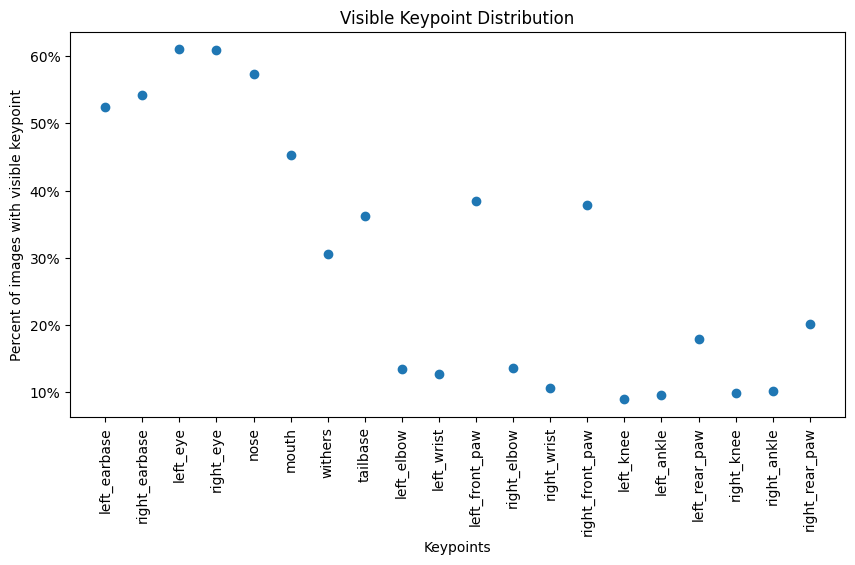

In [62]:
df_keypoints = compute_total_and_percent_by_column(df_keypoints, keypoints)
scatter_plot_of_properties(df_keypoints, keypoints, {'x': 'Keypoints', 'y': 'Percent of images with visible keypoint', 'title': 'Visible Keypoint Distribution'})

<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5076507650765076' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6093609360936093' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4527452745274527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an it

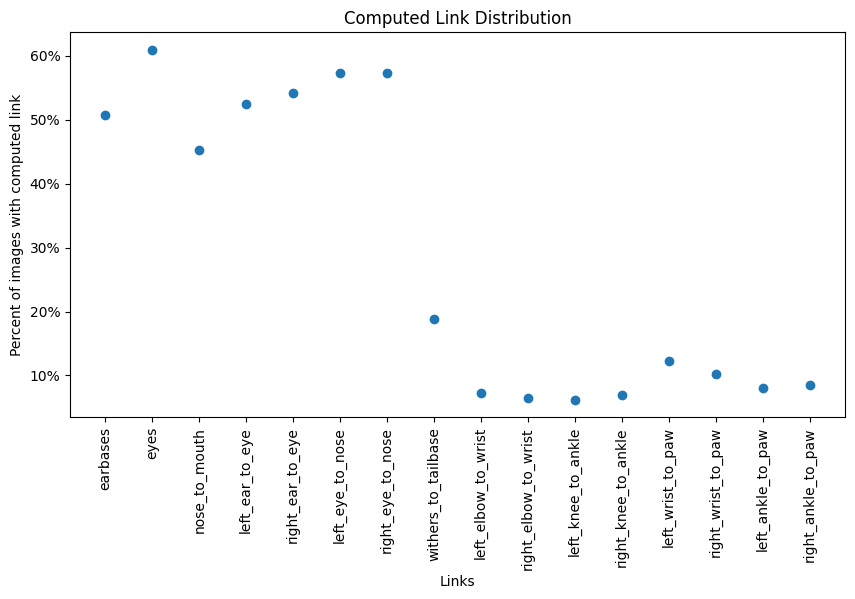

In [63]:
df_links = compute_compound_property(df_keypoints, link_keys, links)
df_links = compute_total_and_percent_by_column(df_links, link_keys[1:])
scatter_plot_of_properties(df_links, link_keys[1:], {'x': 'Links', 'y': 'Percent of images with computed link', 'title': 'Computed Link Distribution'})

<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5067506750675067' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.41044104410441046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07200720072007201' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at['Percent', item] = item_total / num_labels
<ipython-input-60-27322a413d3f>:55: FutureWarning: Setting an 

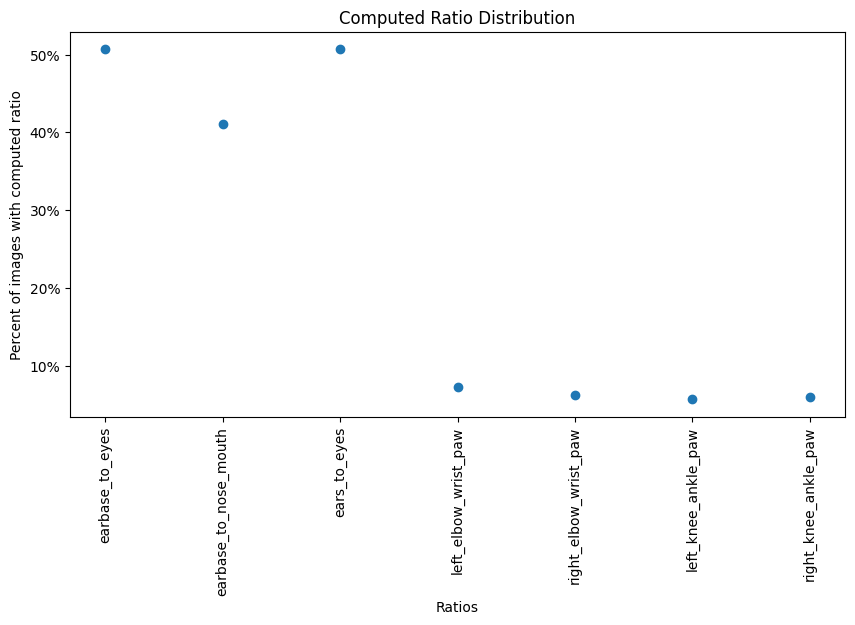

In [64]:
df_ratios = compute_compound_property(df_links, ratio_keys, ratios)
df_ratios = compute_total_and_percent_by_column(df_ratios, ratio_keys[1:])
scatter_plot_of_properties(df_ratios, ratio_keys[1:], {'x': 'Ratios', 'y': 'Percent of images with computed ratio', 'title': 'Computed Ratio Distribution'})